From the HyMoLAP_GR4 model, we build the following SDE model in the L0123001 catchment:

$$
dQ(t)=\left[-\frac{\mu}{\lambda} Q(t)^{2\mu-1}+\frac{1}{\lambda} Perc(t) Pn(t)\right]dt+ \sigma Q(t)dW(t)
$$

with the discrete form using the Euler-Maruyama method:

$$
Q_{t+1} = Q_{t} -\frac{\mu}{\lambda} Q_t^{2\mu-1} +\frac{1}{\lambda} Perc_t \times Pn_t + \sigma Q_t \Delta W_t
$$

where:
- $Q(t)$ is the discharge at time $t$,
- $Perc(t)$ is the percolation at time $t$,
- $Pn(t)$ is the net precipitation,
-  $\sigma$ is the SDE model diffuion parameter,
- $W(t)$ is a Wiener process,
- and $\Delta W_t \sim \mathcal{N}(0, \Delta t=1)$.

In [27]:
import pandas as pd
from matplotlib import pylab as plt
from datetime import datetime
import numpy as np
from numpy import concatenate

import math

import joblib
import matplotlib.dates as mdates
from google.colab import files

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
daily = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alone/Cauquenes7336001__.csv')

daily.head()

,P_mm,Tmx_degC,Tmn_degC,PET_mm,Qobs_mm,Qobs_m3s,Date
0,0.0,24.923411,11.023331,5.541,0.130969,0.943,1979-01-01
1,0.0,26.041955,11.184346,5.827,0.120553,0.868,1979-01-02
2,0.0,27.163775,11.941578,6.044,0.118886,0.856,1979-01-03
3,0.0,27.528073,12.264598,6.100,0.109442,0.788,1979-01-04
4,0.0,26.982496,12.659137,5.890,0.108331,0.780,1979-01-05


In [30]:
#Calibration data
discharge = daily.iloc[7305:8766, 4].to_numpy()
plui = daily.iloc[7305:8766, 0].to_numpy()
etp = daily.iloc[7305:8766, 3].to_numpy()

#Validation data
discharge1 = daily.iloc[8766:9862, 4].to_numpy()
plui1 = daily.iloc[8766:9862, 0].to_numpy()
etp1 = daily.iloc[8766:9862, 3].to_numpy()

In [31]:
#NSE, RMSE, R2
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2


GR4J-HyMoLAP

In [32]:
#NSE, RMSE, R2
def nash_sutcliffe_efficiency(observed, simulated):
    obs_mean = np.mean(observed)
    numerator = np.sum((observed - simulated) ** 2)
    denominator = np.sum((observed - obs_mean) ** 2)

    nse = 1 - (numerator / denominator)
    return nse

def calculate_rmse(observed, predicted):

    rmse = np.sqrt(np.mean((observed - predicted)**2))
    return rmse

def calculate_r2(observed, predicted):

    mean_observed = np.mean(observed)
    mean_predicted = np.mean(predicted)

    numerator = np.sum((observed - mean_observed) * (predicted - mean_predicted))
    denominator = np.sqrt(np.sum((observed - mean_observed)**2)) * np.sqrt(np.sum((predicted - mean_predicted)**2))

    r2 = (numerator / denominator)**2
    return r2


HyMoLAP_GR4J

In [33]:
#Percolation

def Percolation(Pn, En, X1):
   n = len(Pn)
   S = np.zeros(n)
   S[0] =  Pn[0]

   Perc = np.zeros(n)
   ratio = (4.0 / 9.0) * (S[0] / X1)
   Perc[0] = S[0] * (1 - (1 + ratio**4) ** (-0.25))

   Pr = np.zeros(n)
   Pr[0] = Perc[0] + Pn[0]

   for i in range(1, n):
        temp = (S[i-1] / X1) ** 2
        frac = Pn[i] / X1
        Ps = X1 * (1 - temp) * np.tanh(frac) / (1 + (S[i-1] / X1) * np.tanh(frac))

        frac = En[i] / X1
        Es = S[i-1] * (2 - S[i-1] / X1) * np.tanh(frac) / (1 + (1 - S[i-1] / X1) * np.tanh(frac))

        S[i] = S[i-1] + Ps - Es

        ratio = (4.0 / 9.0) * (S[i] / X1)
        Perc[i] = S[i] * (1 - (1 + ratio**4) ** (-0.25))

        Pr[i] = Perc[i] + Pn[i] - Ps

   return Perc

In [34]:
#Calibration
Pn = plui - etp
Pn[Pn < 0] = 0

En = etp - plui
En[En < 0] = 0

#  model
nse = -100
Qsim = np.zeros(len(discharge))
Qsim[0] = discharge[0]
Q1 = np.zeros(len(discharge))

for pp in range(1): #range(20000):
      mu = 1.0876190199933156 #(1.5 - 0.7) * np.random.rand() + 0.7
      lambda_ = 3.7565491745434856 #(10 - 0.1) * np.random.rand() + 0.1
      X1 = 291.8694529794576 #(350 - 250) * np.random.rand() + 250

      Perc = Percolation(Pn, En, X1)

      for k in range(len(discharge)-1):

          Qsim[k+1] = Qsim[k] - (mu/lambda_) * Qsim[k]**(2*mu-1) +  (1/lambda_) * Perc[k] * Pn[k]

      #Nsh criteria
      nsee =  nash_sutcliffe_efficiency(discharge[1:], Qsim[1:])
      if nsee > nse:
          nse = nsee
          mu1 = mu
          lambda1 = lambda_
          X11 = X1
          GR4J_HyM = Qsim.copy()

print(nse)

0.764711330263331


In [35]:
print(mu1)
print(lambda1)
print(X11)

1.0876190199933156
3.7565491745434856
291.8694529794576


In [36]:
#
print('nashe=',nash_sutcliffe_efficiency(discharge[1:],  GR4J_HyM[1:]))
print('rmse=',calculate_rmse(discharge[1:],  GR4J_HyM[1:]))
print('r2=',calculate_r2(discharge[1:],  GR4J_HyM[1:]))

nashe= 0.764711330263331
rmse= 3.031214488067131
r2= 0.7667881114831753


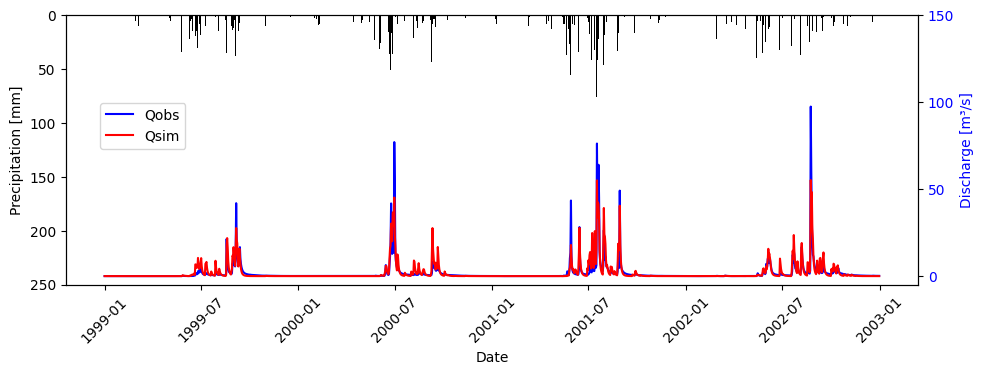

In [37]:
# Create a date range from '01-01-1999' to '12-31-2002'
time1 = np.datetime64('1999-01-01')
time2 = np.datetime64('2002-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(11., 3.5))

# Plot a histogram for precipitation on ax1
ax1.bar(time, plui, color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date')

# Set y-axis parameters for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 250)
ax1.set_yticks(np.arange(0, 251, 50))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharges
ax2 = ax1.twinx()
ax2.plot(time, discharge, 'b', label='Qobs')


# Plot the mean of the simulated trajectories
ax2.plot(time, GR4J_HyM, 'red', label='Qsim')

# Set y-axis parameters for daily discharges
ax2.set_ylabel('Discharge [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-5, 150)
ax2.set_yticks(np.arange(0, 151, 50))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.65))

# Display the grid
#plt.grid(True)

# Show the plot
plt.show()


Validation

In [38]:
Pn1 = plui1 - etp1
Pn1[Pn1 < 0] = 0

En1 = etp1 - plui1
En1[En1 < 0] = 0

In [39]:
# Simulation
size = len(discharge1)
Perc1 = Percolation(Pn1, En1, X11)

#EQUATION
Qval = np.zeros(size)
Qval[0] = discharge1[0]

for k in range(0, size-1):

    Qval[k+1] = Qval[k] - (mu1/lambda1) * Qval[k]**(2*mu1-1) +  (1/lambda1) * Perc1[k] * Pn1[k]

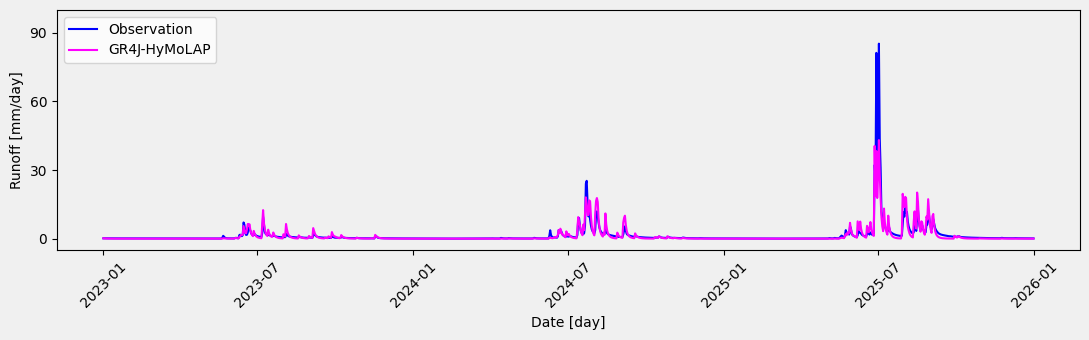

In [40]:
# Generate dates
time1 = np.datetime64('2023-01-01')
time2 = np.datetime64('2025-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(11., 3.5))

# Background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated runoff
ax.plot(time, discharge1, 'b',  label='Observation', linewidth=1.5)
ax.plot(time, Qval, 'magenta', label='GR4J-HyMoLAP', linewidth=1.5)

# X-axis settings (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis settings
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-5, 100)
ax.set_yticks(np.arange(0, 101, 30))

# Add legend
ax.legend(loc='upper left')

# Show grid
#plt.grid(True)

# Avoid overlap
plt.tight_layout()

# Save figure
plt.savefig("Cauqueness_GR4J-HyMoLAP.jpeg", format='jpeg', dpi=700)

#files.download("Cauqueness_GR4J-HyMoLAP.jpeg")

# Display plot
plt.show()


In [41]:
nse_value = nash_sutcliffe_efficiency(discharge1, Qval)
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

rmse = calculate_rmse(discharge1, Qval)
print('rmse=', rmse)

r2 = calculate_r2(discharge1, Qval)
print('r2=', r2)

Nash-Sutcliffe Efficiency (NSE): 0.752186632294555
rmse= 2.3347012026435703
r2= 0.759672695793465


SDE

In [42]:
# Compute the diffusion parameter

Perc = Percolation(Pn, En, X11)

num = 0
den = 0
for k in range(1, len(discharge)):
  num = num + (discharge[k] - discharge[k - 1] + (mu1/lambda1) * discharge[k-1]**(2*mu1-1) - (1/lambda1) * Perc[k-1] * Pn[k - 1])**2
  den = den + (discharge[k-1])**2

sigma = np.sqrt(num/den)

In [43]:
print(sigma)

0.42796326641595933


UQ

In [44]:
# Simulation with the SDE
size = len(discharge)
n_traj = 10000
QQ = np.zeros((size,n_traj))

Perc = Percolation(Pn, En, X11)

for i in range(n_traj):

   # Model
   S = np.zeros(size)
   S[0] = discharge[0]

   for k in range(1, len(discharge)):
      if S[k - 1] < 0:
         S[k - 1] = 0

      S[k] = (S[k - 1] - (mu1/lambda1) * S[k-1]**(2*mu1-1) + (1/lambda1) * Perc[k-1] * Pn[k-1] +
                     sigma * (plui[k-1]) * np.random.normal(loc=0, scale=np.sqrt(1)))

   QQ[:, i] = S.copy()

mean_trajectory = np.mean(QQ, axis=1)


In [45]:
nse_value = nash_sutcliffe_efficiency(discharge[1:], mean_trajectory[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge[1:], mean_trajectory[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.7290396320193688
rmse= 3.2528875297076816


In [46]:
# Build 90% quantile interval
min_trajectory = np.percentile(QQ, 5, axis=1)
max_trajectory = np.percentile(QQ, 95, axis=1)

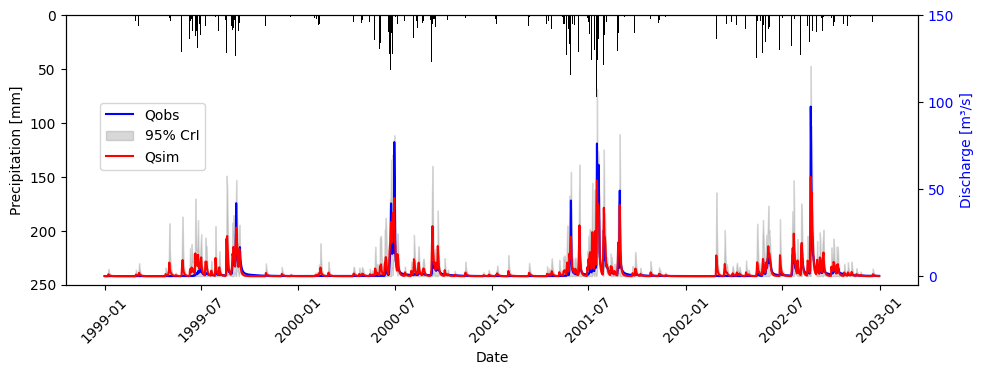

In [47]:
# Create a date range from '01-01-1999' to '12-31-2002'
time1 = np.datetime64('1999-01-01')
time2 = np.datetime64('2002-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axes with a reduced figure size
fig, ax1 = plt.subplots(figsize=(11., 3.5))

# Plot a histogram for precipitation on ax1
ax1.bar(time, plui, color='black')

# Format the x-axis labels
ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

ax1.set_xlabel('Date')

# Set y-axis parameters for precipitation
ax1.set_ylabel('Precipitation [mm]', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_ylim(0, 250)
ax1.set_yticks(np.arange(0, 251, 50))

# Invert the y-axis and place ticks on the left for precipitation
ax1.invert_yaxis()
ax1.yaxis.set_label_position("left")

# Create a second y-axis to plot discharges
ax2 = ax1.twinx()
ax2.plot(time, discharge, 'b', label='Qobs')

# Plot minimum, maximum, and mean values as a confidence region
ax2.fill_between(time, min_trajectory, max_trajectory, color='gray', alpha=0.3, label='95% CrI')

# Plot the mean of the simulated trajectories
ax2.plot(time, mean_trajectory, 'red', label='Qsim')

# Set y-axis parameters for daily discharges
ax2.set_ylabel('Discharge [m³/s]', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
ax2.set_ylim(-5, 150)
ax2.set_yticks(np.arange(0, 151, 50))

# Add a legend inside the plot
fig.legend(loc='upper left', bbox_to_anchor=(0.15, 0.65))

# Display the grid
#plt.grid(True)

# Show the plot
plt.show()


In [48]:
observed = discharge
lower_bound = min_trajectory
upper_bound = max_trajectory

# Calculate the "hits" and "misses" for the Hit Rate (HR)
hits = np.sum((observed >= lower_bound) & (observed <= upper_bound))
misses = len(observed) - hits
hit_rate = (hits / (hits + misses)) * 100  # HR formula in percentage

# Calculate the Mean Prediction Interval Width (MPIW)
mpiw = np.mean(upper_bound - lower_bound)

print(f"Hit Rate (HR) in %: {hit_rate:}")
print(f"Mean Prediction Interval Width (MPIW): {mpiw}")


Hit Rate (HR) in %: 67.5564681724846
Mean Prediction Interval Width (MPIW): 5.077364404807242


Validation

In [49]:
# Simulation with the SDE
size1 = len(discharge1)
n_traj = 100000
QQ1 = np.zeros((size1,n_traj))

Perc1 = Percolation(Pn1, En1, X11)

for i in range(n_traj):

   # Model
   S1 = np.zeros(size1)
   S1[0] = discharge1[0]

   for k in range(1, len(discharge1)):
      if S1[k - 1] < 0:
         S1[k - 1] = 0

      S1[k] = (S1[k - 1] - (mu1/lambda1) * S1[k-1]**(2*mu1-1) + (1/lambda1) * Perc1[k-1] * Pn1[k-1] +
                     sigma * (S1[k-1]) * np.random.normal(loc=0, scale=np.sqrt(1)))

   QQ1[:, i] = S1.copy()

mean_trajectory1 = np.mean(QQ1, axis=1)


In [50]:
nse_value = nash_sutcliffe_efficiency(discharge1[1:], mean_trajectory1[1:])
print("Nash-Sutcliffe Efficiency (NSE):", nse_value)

print('rmse=',calculate_rmse(discharge1[1:], mean_trajectory1[1:]))

Nash-Sutcliffe Efficiency (NSE): 0.7533485221614147
rmse= 2.330223963448249


In [51]:
# Build 90% quantile interval
min_trajectory1 = np.percentile(QQ1, 5, axis=1)
max_trajectory1 = np.percentile(QQ1, 95, axis=1)

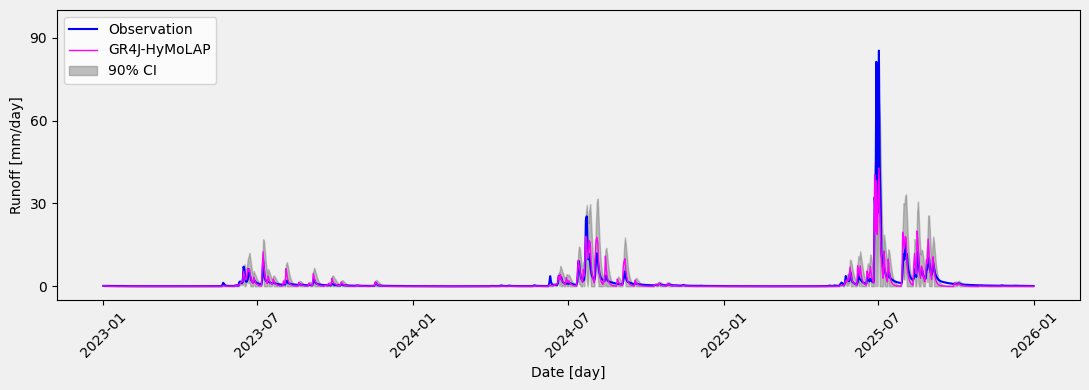

In [52]:
# Generate dates
time1 = np.datetime64('2023-01-01')
time2 = np.datetime64('2025-12-31')
time = np.arange(time1, time2 + np.timedelta64(1, 'D'), dtype='datetime64[D]')

# Create a figure and axis
fig, ax = plt.subplots(figsize=(11., 4.))

# Set background color
fig.patch.set_facecolor('#f0f0f0')
ax.set_facecolor('#f0f0f0')

# Plot observed and simulated discharges
ax.plot(time, discharge1, 'b', label='Observation', linewidth=1.5)
ax.plot(time, mean_trajectory1, 'magenta', label='GR4J-HyMoLAP', linewidth=1.)

# Plot minimum, maximum and mean values as a confidence region
ax.fill_between(time, min_trajectory1, max_trajectory1, color='gray', alpha=0.5, label='90% CI')

# X-axis parameters (date format)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 7]))
plt.xticks(rotation=45)
ax.set_xlabel('Date [day]')

# Y-axis parameters
ax.set_ylabel('Runoff [mm/day]')
ax.tick_params(axis='y', labelcolor='black')
ax.set_ylim(-5, 100)
ax.set_yticks(np.arange(0, 101, 30))

# Add legend
ax.legend(loc='upper left')

# Display grid
#plt.grid(True)

# Avoid label overlaps
plt.tight_layout()

# Save figure
plt.savefig("Cauqueness_UQ.jpeg", format='jpeg', dpi=500)

# Download option (commented)
#files.download("Cauqueness_UQ.jpeg")

# Show plot
plt.show()


In [53]:
observed = discharge1
lower_bound = min_trajectory1
upper_bound = max_trajectory1

# Calculate the "hits" and "misses" for the Hit Rate (HR)
hits = np.sum((observed >= lower_bound) & (observed <= upper_bound))
misses = len(observed) - hits
hit_rate = (hits / (hits + misses)) * 100  # HR formula in percentage

# Calculate the Mean Prediction Interval Width (MPIW)
mpiw = np.mean(upper_bound - lower_bound)

print(f"Hit Rate (HR) in %: {hit_rate:}")
print(f"Mean Prediction Interval Width (MPIW): {mpiw}")

Hit Rate (HR) in %: 34.12408759124087
Mean Prediction Interval Width (MPIW): 2.0976516864501846
